# Image Style Transfer with Deep Neural Networks

* Project: To transfer style of one image to another
* Source: Udacity deep learning course and paper on Image Style Transfer Using Convolutional Neural Networks, by Gatys in PyTorch.
* Author: Shashi Kiran Chilukuri

### Importing libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import torch
import torch.optim as optim
from torchvision import transforms, models

### Checking for CUDA (GPU device)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading images

Style transfer relies on separating the **content** and **style** of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components:

* objects and their arrangement are similar to that of the content image
* style, colors, and textures are similar to that of the style image


Below is the load_image function for loading in any type and size of image and also converts images to normalized Tensors.

In [8]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [9]:
# load in content and style image
content = load_image('images/Shashi pic-min.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [11]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

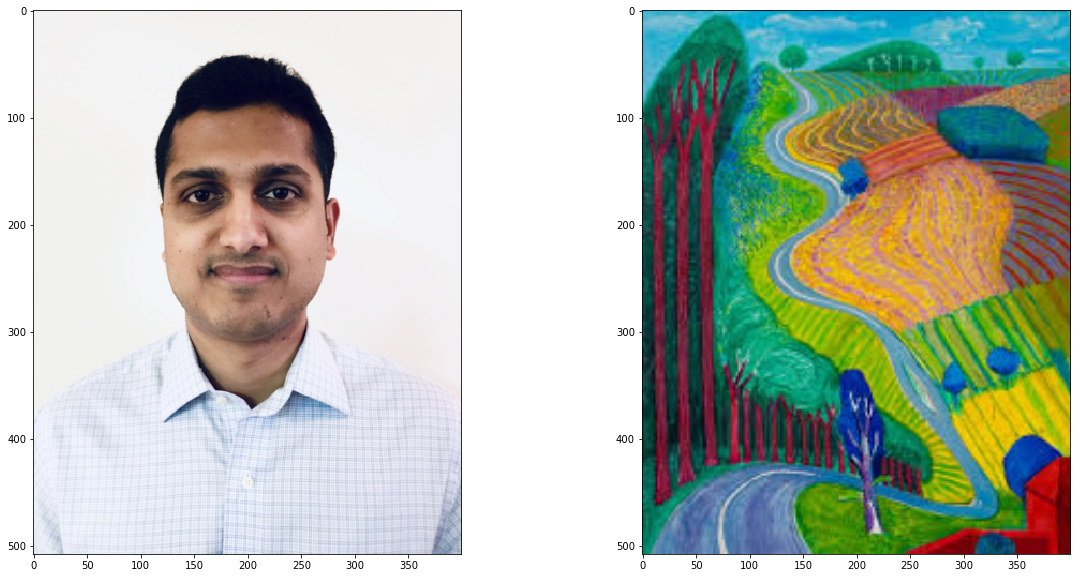

In [13]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
plt.show()

### Loading the model

For this style transfer project, we will be using VGG19 model. VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below

In [15]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)
    
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Getting Content and style features

To get the content and style representations of an image, we have to pass an image forward throug the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [17]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
        # mapping of layer names to the names found in the paper for 
        # the content representation and the style representation
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Calculating Gram matrix

The Gram matrix of a convolutional layer can be calculated as follows:

* Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

In [18]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    _, d, h, w = tensor.size()     # get the batch_size, depth, height, and width of the Tensor
    tensor = tensor.view(d, h * w) # reshape so we're multiplying the features for each channel
    gram = torch.mm(tensor, tensor.t())     # calculate the gram matrix
    
    return gram 

### Extracting freatures and applying gram_matrix on our images

In [20]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

### Loss and Weights

**Individual Layer style weights:**Range of  weight should be between 0-1 in these layers. By weighting earlier layers (conv1_1 and conv2_1) more, you can expect to get larger style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

**Content and Style weight:**Just like in the paper, we define an alpha (content_weight) and a beta (style_weight). This ratio will affect how stylized your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [21]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

### Updating the Target & Calculating Losses

Total loss:  228256112.0


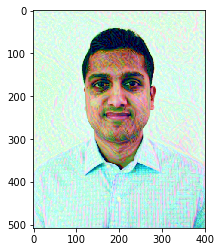

Total loss:  101434184.0


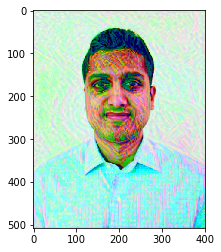

Total loss:  47574164.0


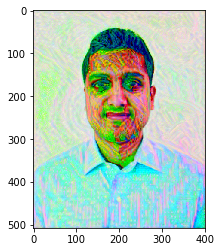

Total loss:  24857580.0


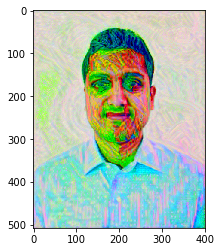

Total loss:  16123011.0


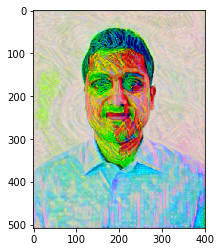

In [22]:
show_every = 400 # for displaying the target image, intermittently
optimizer = optim.Adam([target], lr=0.003)
steps = 2000     # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)     # get the features from your target image
    
    #### Calculating the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    #### Calculating the style loss
    style_loss = 0            # initialize the style loss to 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    #### calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

### Display the content and Target image

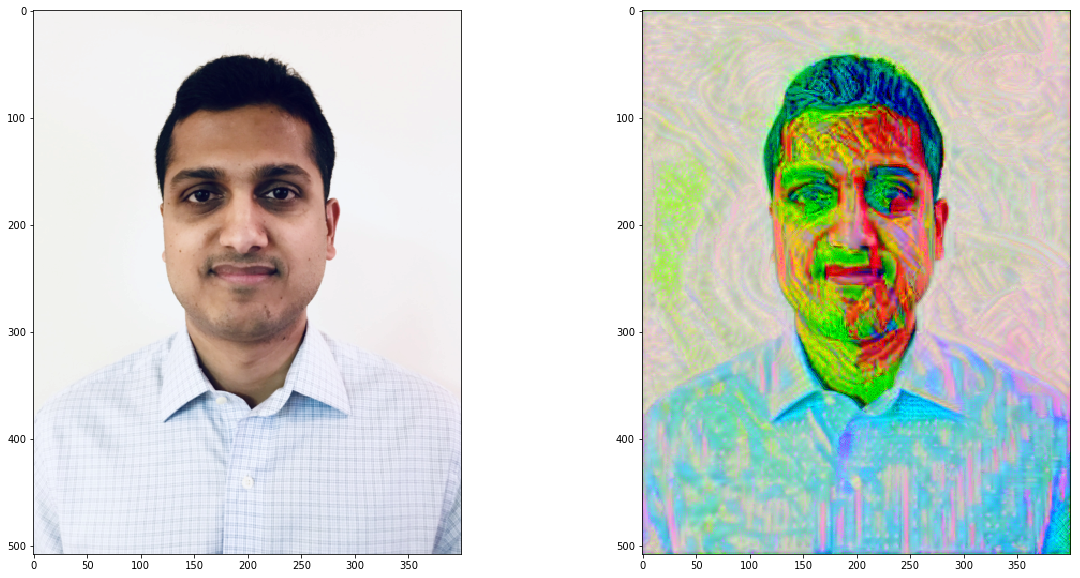

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
plt.show()